# Parte 0 - Instalação (usando Anaconda Python)

Abaixo estão os comandos usados para instalar todas as dependências necessárias para esta aula. Se você não tem uma GPU NVidia troque `tensorflow-gpu` por `tensorflow`.

    > conda create -n CV-NN python=3.6
    > conda activate CV-NN
    > conda install tensorflow-gpu scikit-learn jupyter[notebook] numpy keras

Os comandos acima criam um ambiente virtual com Python 3.6 (3.7 não funciona ainda). Isto não é necessário, mas pode ser interessante para organizar melhor as dependências dos seus projetos. Uma vantagem de usar o Anaconda é que ele já instala o CUDA SDK automaticamente (no caso de usar `tensorflow-gpu`). 

# Parte 1 - Classificação categórica

Na última atividade vimos um exemplo de **classificação binária**, em que classificamos imagens em pertencendo ou não a uma classe (*cachorros* vs *faces*). Nesta atividade exercitaremos a classificação em categorias e para isto usaremos um modelo que se adapta bem a este tipo de situação: *Regressão logística* e a *entropia categórica*.

Além do scikit-learn, usado no roteiro passado, neste roteiro usaremos também a biblioteca [keras](http://keras.io) para treinar redes neurais que façam a classificação categórica de imagens de dígitos manuscritos. Veja abaixo o código para carregar os dados e um exemplo de imagem que usaremos.

Using TensorFlow backend.
/home/tirta/.local/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.24.1) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


# Imagens: 60000
Tamanho: (28, 28)
Primeiro número: 5


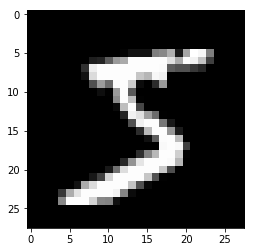

In [2]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
%matplotlib inline

(X, y), (Xt, yt) = mnist.load_data()
print('# Imagens:', y.shape[0])
print('Tamanho:', X[0].shape)
print('Primeiro número:', y[0])
plt.imshow(X[0], cmap='gray')

Assim como na Atividade 3, dividimos as imagens disponíveis em um conjunto conhecido que usaremos para o treinamento de nossa rede (`X` e `y`) e um conjunto que só usaremos para avaliação (`Xt, yt`). Isto ajuda a não subestimar o erro em imagens desconhecidas. 

Nesta primeira parte iremos criar um modelo diretamente usando Regressão Logística. Para isto precisamos "deitar" a matriz da imagem $28\times 28$ em um grande vetor de dimensão $784$. 

**Exercício**: Faça isto abaixo e salve os dados transformados como `Xlr` e `Xtlr`.

In [0]:
import numpy as np
xlr = np.reshape(X,(X.shape[0],(X.shape[1]*X.shape[2])))
xtlr = np.reshape(Xt,(Xt.shape[0],(Xt.shape[1]*Xt.shape[2])))

A classe `sklearn.linear_model.LogisticRegression` é capaz de lidar com os rótulos das classes diretamente. Basta enviar o vetor `y` diretamente para a função de treinamento. 

**Dica**: para usarmos o modelo visto em sala de aula precisamos setar o parâmetro `multi_class` como `'multinomial'`. O treinamento é mais rápido se usarmos o solver `'saga'`

**Aviso**: o treinamento do modelo abaixo demora cerca de 5 minutos.

In [0]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(solver='lbfgs', multi_class='multinomial').fit(xlr, y)

Como visto na expositiva, a *Regressão Logística* estima a probabilidade que um objeto seja de uma determinada classe. No caso dos dígitos temos 10 classes (`0` a `9`), logo nossa saída deverá ter dimensão 10 e cada componente deverá conter a probabilidade da imagem ter o dígito correspondente. 

O método `predict_proba(X)` calcula a probabilidade de cada classe para um conjunto de imagens passado em `X` (um por linha). 

**Pergunta**: suponha que seu classificador retornou, para a imagem acima, o seguinte vetor ao chamar `predict_proba`:

`[0, 0, 0, 0, 0, 0.6, 0.3, 0, 0, 0.1]`

Interprete o resultado obtido.

A probabilidade de ser o numero 6 é maior, representando 60% de acerto, porém, tem uma menor probabilidade de ser o número 7 ou 9.

**Exercício**: Assim como feito na atividade 3, avalie os resultados de seu classificador usando a função `score` e comente os resultados.

In [0]:
clf.score(xlr,y)

0.9340666666666667

Representa que possui 93% de acuracia

**Exercício**: Suponha que você precisa ler um número de 5 dígitos. Usando o classificador acima, qual seria a probabilidade de que este número seja lido corretamente? Este resultado é satisfatório?

71%, não muito satisfátirio

# Parte 2 - Redes Neurais Multi-nível

**Aviso**: nos próximos exercícios usaremos a biblioteca [keras]

Nesta parte iremos criar uma rede neural "simples" com vários níveis. Diferentemente do classificador do *Scikit-learn*, ao trabalhar com redes neurais precisamos trabalhar com as probabilidades de maneira explícita. Para isto precisamos transformar nosso vetor de saída (que contém o número escrito na imagem) em uma matriz de classes binária.

**Exercício**: Pesquise o que é uma matriz de classes binária (também conhecida como *one hot encoding*)

https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f

É um processo que converte variáveis em tabelas binárias para facilitar na previsão. Ou seja, essa matriz de classes binárias é uma ferramenta que aumentará a probabilidade de acerto da previsão

**Exercício**: Use a função `to_categorical` do keras para converter `y` para uma matriz de classes binária `y_oe`. Faça o mesmo com `yt`

In [0]:
from keras.utils import to_categorical
y_oe=to_categorical(y)
yt_oe=to_categorical(yt)

**Exercício**: os dados das imagens estão no intervalo $[0,255]$. Transforme-os para estarem no intervalor $[0, 1]$. Redes neurais tem melhor desempenho no intervalo menor. Salve os dados como `Xnn` e `Xtnn`

In [0]:
xnn = xlr/255.0
xtnn = xtlr/255.0

Nossa rede neural irá retornar, como saída, um vetor de dimensão 10 igual as linhas de `y_oe`.

----

Vamos agora construir a arquitetura de nossa rede neural. Seguiremos as seguintes instruções:

1. Nosso modelo será representado pela classe `Sequential`, que é uma lista de camadas tal que a saída de uma camada é passada diretamente para a próxima.
1. Cada camada será do tipo `Dense`, ou seja, cada nó da camada está ligado a todos os nós da camada anterior. A função de ativação usada será `'relu'.`
1. A saída será uma camada `Dense` também, mas com ativação `'softmax'`. Esta função de ativação computa as mesmas probabilidades da Regressão Logística.


**Exercício**: instancie um objeto de `Sequential` e use seu método `add()` para adicionar uma camada densa de tamanho $784$ e uma camada densa de saída. 

**Dica**: 
1. veja as documentações das classes [`Sequential`](https://keras.io/getting-started/sequential-model-guide/) e [`Dense`](https://keras.io/layers/core/#dense). As possíveis funções de ativação são mostradas [neste link](https://keras.io/activations/). 
2. Ao adicionar a primeira camada é preciso dizer qual é o tamanho da entrada da rede. Isto pode ser feito usando o argumento `input_dim` de `Dense()`
2. `Sequential.add()` é capaz de adivinhar o tamanho da entrada das próximas camadas baseado nos parâmetros passados. 
3. A camada de saída deve ter tamanho igual ao número de classes usadas (10, uma para cada dígito).

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(784, input_dim=784))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))

Com nosso modelo pronto precisamos definir quais serão as opções usadas em seu treinamento. Fazemos isto com o método `compile`. A chamada abaixo já foi configurada supondo que sua rede se chama `model`.

In [0]:
# For a multi-class classification problem
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Vamos então treinar nosso modelo. Seguimos o mesmo padrão do *scikit-learn*, ou seja, chamamos o método `fit` com os dados de treinamento `Xlr` e `y_oe`. Iremos treinar com os seguintes argumentos: `batch_size=200, epochs=10`. Se quiser ter um relatório detalhado do progresso, adicione `verbose=2`.

In [0]:
model.fit(xnn,y_oe,200,10,2)

Epoch 1/10
 - 3s - loss: 0.2784 - acc: 0.9185
Epoch 2/10
 - 2s - loss: 0.1065 - acc: 0.9683
Epoch 3/10
 - 2s - loss: 0.0689 - acc: 0.9797
Epoch 4/10
 - 2s - loss: 0.0489 - acc: 0.9850
Epoch 5/10
 - 2s - loss: 0.0352 - acc: 0.9897
Epoch 6/10
 - 2s - loss: 0.0268 - acc: 0.9921
Epoch 7/10
 - 2s - loss: 0.0201 - acc: 0.9942
Epoch 8/10
 - 2s - loss: 0.0152 - acc: 0.9956
Epoch 9/10
 - 2s - loss: 0.0118 - acc: 0.9965
Epoch 10/10
 - 2s - loss: 0.0092 - acc: 0.9974


**Exercício**: Use o método [`model.evaluate`](https://keras.io/models/model/#evaluate) para avaliar a rede neural treinada e avalie seus resultados levando em conta a mesma situação da Parte 1 (leitura de número com 5 dígitos).

In [0]:
model.evaluate(xnn,y_oe)

60000/60000 [==============================] - 4s 64us/step


[0.007308363150974522, 0.99785]

# Parte 3 - Redes Convolucionais

Redes convolucionais são redes neurais cujas camadas fazem operações que podem ser interpretadas como processamentos de imagens.

* Conv2D - equivale a uma convolução, ou seja, uma combinação linear dos pixels na vizinhança de cada pixel
* MaxPooling2d - equivale a redimensionar a imagem para metade de sua altura e largura.
* Flatten - transforma a imagem em um vetor unidimensional. 

Redes Convolucionais são, normalmente, bastante complexas. Por isto nesta parte da atividade iremos trabalhar em cima de uma rede pré-configurada. Nossos exercícios serão treiná-la com um número crescente de épocas e adicionar ou remover camadas. 

Veja abaixo uma rede contendo uma camada de cada um dos tipos mostrados acima. 

In [0]:
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten
from keras import backend as K
K.set_image_dim_ordering('th')

model_cnn = Sequential()
model_cnn.add(Conv2D(32, (5, 5), input_shape=(1, 28, 28), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Flatten())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dense(10, activation='softmax'))
model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Assim como a rede anterior, este modelo depende dos dados estarem em um formato específico. As imagens devem estar no formato $(C, H, W)$, onde $C$ é o número de canais (1 para níveis de cinza, 3 para RGB) e $H$ e $W$ são a altura e largura da imagem. O treinamento é feito usando o método `model_cnn.fit`, igual ao exercício anterior.

**Exercício**: faça o treinamento da rede acima para 1 época.

In [0]:
Xcnn = xnn.reshape(xnn.shape[0], 1, 28, 28).astype('float32')
Xtcnn = xtnn.reshape(xtnn.shape[0], 1, 28, 28).astype('float32')

model_cnn.fit(Xcnn, y_oe, validation_data=(Xtcnn, yt_oe), batch_size=200, verbose=2, epochs=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
 - 4s - loss: 0.2400 - acc: 0.9317 - val_loss: 0.0755 - val_acc: 0.9784


**Exercício**: faça agora o treinamento para 10 épocas. Os resultados melhoraram?

In [0]:
model_cnn.fit(Xcnn, y_oe, validation_data=(Xtcnn, yt_oe), batch_size=200, verbose=2, epochs=10)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 3s - loss: 0.0661 - acc: 0.9801 - val_loss: 0.0544 - val_acc: 0.9821
Epoch 2/10
 - 3s - loss: 0.0449 - acc: 0.9866 - val_loss: 0.0425 - val_acc: 0.9852
Epoch 3/10
 - 3s - loss: 0.0345 - acc: 0.9901 - val_loss: 0.0362 - val_acc: 0.9881
Epoch 4/10
 - 3s - loss: 0.0270 - acc: 0.9917 - val_loss: 0.0340 - val_acc: 0.9885
Epoch 5/10
 - 3s - loss: 0.0217 - acc: 0.9931 - val_loss: 0.0394 - val_acc: 0.9877
Epoch 6/10
 - 3s - loss: 0.0171 - acc: 0.9947 - val_loss: 0.0443 - val_acc: 0.9860
Epoch 7/10
 - 3s - loss: 0.0140 - acc: 0.9956 - val_loss: 0.0355 - val_acc: 0.9891
Epoch 8/10
 - 3s - loss: 0.0108 - acc: 0.9969 - val_loss: 0.0320 - val_acc: 0.9895
Epoch 9/10
 - 3s - loss: 0.0084 - acc: 0.9974 - val_loss: 0.0365 - val_acc: 0.9883
Epoch 10/10
 - 3s - loss: 0.0063 - acc: 0.9983 - val_loss: 0.0383 - val_acc: 0.9895


**Exercício**: Os parâmetros de uma camada `Conv2D` são

1. o número de filtors de convolução usados
1. a dimensão dos filtros (como uma tupla)
1. a função de ativação (sempre usaremos 'relu')

Crie um novo modelo com uma camada de convolução a mais após a camada de `MaxPooling`. Seu modelo deverá fazer 20 convoluções na primeira camada e 20 na segunda. Treine uma época do modelo e compare com o modelo de exemplos. Os resultados são melhores? E se 10 épocas forem executadas?

In [0]:
new_model_cnn = Sequential()
new_model_cnn.add(Conv2D(20, (5, 5), input_shape=(1, 28, 28), activation='relu'))
new_model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
new_model_cnn.add(Conv2D(20, (5, 5), input_shape=(1, 28, 28), activation='relu'))
new_model_cnn.add(Flatten())
new_model_cnn.add(Dense(128, activation='relu'))
new_model_cnn.add(Dense(10, activation='softmax'))
new_model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
new_model_cnn.fit(Xcnn, y_oe, validation_data=(Xtcnn, yt_oe), batch_size=200, verbose=2, epochs=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
 - 4s - loss: 0.2659 - acc: 0.9264 - val_loss: 0.0681 - val_acc: 0.9782


In [0]:
new_model_cnn.fit(Xcnn, y_oe, validation_data=(Xtcnn, yt_oe), batch_size=200, verbose=2, epochs=10)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 3s - loss: 0.0650 - acc: 0.9802 - val_loss: 0.0398 - val_acc: 0.9877
Epoch 2/10
 - 3s - loss: 0.0441 - acc: 0.9862 - val_loss: 0.0344 - val_acc: 0.9886
Epoch 3/10
 - 3s - loss: 0.0334 - acc: 0.9898 - val_loss: 0.0361 - val_acc: 0.9884
Epoch 4/10
 - 3s - loss: 0.0288 - acc: 0.9908 - val_loss: 0.0371 - val_acc: 0.9883
Epoch 5/10
 - 3s - loss: 0.0243 - acc: 0.9922 - val_loss: 0.0388 - val_acc: 0.9885
Epoch 6/10
 - 3s - loss: 0.0191 - acc: 0.9940 - val_loss: 0.0335 - val_acc: 0.9898
Epoch 7/10
 - 3s - loss: 0.0168 - acc: 0.9945 - val_loss: 0.0277 - val_acc: 0.9910
Epoch 8/10
 - 3s - loss: 0.0137 - acc: 0.9958 - val_loss: 0.0370 - val_acc: 0.9895
Epoch 9/10
 - 3s - loss: 0.0127 - acc: 0.9959 - val_loss: 0.0300 - val_acc: 0.9915
Epoch 10/10
 - 3s - loss: 0.0101 - acc: 0.9966 - val_loss: 0.0368 - val_acc: 0.9903


**Exercício**: Os parâmetros de uma camada `MaxPooling2D` são

1. uma tupla contendo a vizinhança usada para fazer o redimensionamento. 

Crie um novo modelo baseado no acima que adiciona uma camada deste tipo com os mesmos parâmetros da primeira após a segunda convolução e treine uma época dele. Os resultados são melhores? E com 10 épocas? Como o tempo de treinamento é afetado?

In [0]:
new_model_cnn = Sequential()
new_model_cnn.add(Conv2D(20, (5, 5), input_shape=(1, 28, 28), activation='relu'))
new_model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
new_model_cnn.add(Conv2D(20, (5, 5), input_shape=(1, 28, 28), activation='relu'))
new_model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
new_model_cnn.add(Flatten())
new_model_cnn.add(Dense(128, activation='relu'))
new_model_cnn.add(Dense(10, activation='softmax'))
new_model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
new_model_cnn.fit(Xcnn, y_oe, validation_data=(Xtcnn, yt_oe), batch_size=200, verbose=2, epochs=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
 - 4s - loss: 0.3466 - acc: 0.9001 - val_loss: 0.1374 - val_acc: 0.9572


In [0]:
new_model_cnn.fit(Xcnn, y_oe, validation_data=(Xtcnn, yt_oe), batch_size=200, verbose=2, epochs=10)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 3s - loss: 0.0860 - acc: 0.9743 - val_loss: 0.0607 - val_acc: 0.9804
Epoch 2/10
 - 3s - loss: 0.0592 - acc: 0.9817 - val_loss: 0.0467 - val_acc: 0.9840
Epoch 3/10
 - 3s - loss: 0.0467 - acc: 0.9858 - val_loss: 0.0434 - val_acc: 0.9855
Epoch 4/10
 - 3s - loss: 0.0386 - acc: 0.9885 - val_loss: 0.0376 - val_acc: 0.9879
Epoch 5/10
 - 3s - loss: 0.0330 - acc: 0.9897 - val_loss: 0.0335 - val_acc: 0.9894
Epoch 6/10
 - 3s - loss: 0.0294 - acc: 0.9908 - val_loss: 0.0316 - val_acc: 0.9900
Epoch 7/10
 - 3s - loss: 0.0256 - acc: 0.9920 - val_loss: 0.0364 - val_acc: 0.9893
Epoch 8/10
 - 3s - loss: 0.0225 - acc: 0.9932 - val_loss: 0.0307 - val_acc: 0.9893
Epoch 9/10
 - 3s - loss: 0.0197 - acc: 0.9936 - val_loss: 0.0311 - val_acc: 0.9895
Epoch 10/10
 - 3s - loss: 0.0168 - acc: 0.9948 - val_loss: 0.0276 - val_acc: 0.9905


Testar diversas arquiteturas é uma tarefa muito comum em Visão Computacional. 

**Exercício**: Compare os resultados de sua melhor rede com os resultados das duas partes anteriores. Qual foi o ganho de acurácia no problema da leitura do número com 5 dígitos?

# Parte final

**Exercício**: tire uma foto de 5 números escritos à mão por você. Separe cada um dos números, redimensione-os para uma imagem $28\times 28$, passe cada um pelo seu melhor modelo desta aula e retorne a leitura do número por inteiro.

**Dica**: sua foto pode conter somente a folha em branco e os dígitos em preto. Você pode supor que nenhuma parte de um dígito encosta no outro e que a imagem é binarizável usando uma operação simples de limiar (*threshold*).

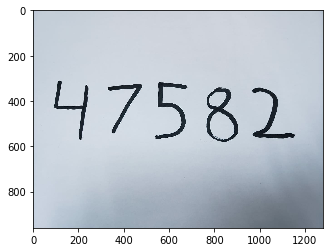

In [4]:
import cv2
img = cv2.imread("numbers.jpeg")
plt.imshow(img)